In [ ]:
# Ensemble training (2 years of testing, 1 year of validation, the rest is training)
    # Learned weights on validation data (Constrained optimization)
    # Meta-learning using an other ML model

# Models used:
# - XGBoost
# - Neural Network
# - Logistic Regression
# - LSTM


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os


In [3]:
# Set up paths and load data
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
print(parent_dir)

interpolated_dir = os.path.join(parent_dir, "dataset_interpolated_with_overtime")
features = ["score_difference", "timestep", "type.id", "relative_strength", "home_has_possession", "end.down", "end.yardsToEndzone", "end.distance", "field_position_shift", "home_timeouts_left", "away_timeouts_left"]

# Import necessary modules
from sklearn.metrics import brier_score_loss, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize
import pickle
import warnings
warnings.filterwarnings('ignore')


/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML


In [4]:
# Load data for ensemble training
import process_data
training_data = process_data.load_data(interpolated_dir, 
                                       years = [2016, 2017, 2018, 2019, 2020], 
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win")

validation_data = process_data.load_data(interpolated_dir, 
                                       years = [2021], 
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win")

ensemble_data = process_data.load_data(interpolated_dir, 
                                         years = [2022, 2023], 
                                         history_length = 0, 
                                         features = features, 
                                         label_feature = "home_win")

test_data = process_data.load_data(interpolated_dir, 
                                   years = [2024],
                                   history_length = 0, 
                                   features = features, 
                                   label_feature = "home_win")

training_data_seq = process_data.load_data(interpolated_dir, 
                                       years = [2016, 2017, 2018, 2019, 2020], 
                                       history_length = 4, 
                                       features = features, 
                                       label_feature = "home_win")

validation_data_seq = process_data.load_data(interpolated_dir, 
                                         years = [2021], 
                                         history_length = 4, 
                                         features = features, 
                                         label_feature = "home_win")

ensemble_data_seq = process_data.load_data(interpolated_dir, 
                                         years = [2022, 2023], 
                                         history_length = 4, 
                                         features = features, 
                                         label_feature = "home_win")

test_data_seq = process_data.load_data(interpolated_dir, 
                                   years = [2023, 2024],
                                   history_length = 4, 
                                   features = features, 
                                   label_feature = "home_win")


Loading data for 2022
skipping  2022
Loading data for 2024
skipping  2024
Loading data for 2023
skipping  2023
Loading data for 2015
skipping  2015
Loading data for .DS_Store
Loading data for 2017
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML/dataset_interpolated_with_overtime/2017/game_400951752.csv
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML/dataset_interpolated_with_overtime/2017/game_400951752.csv
  NaN Label found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML/dataset_interpolated_with_overtime/2017/game_400951632.csv
  NaN Label found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML/dataset_interpolated_with_overtime/2017/game_400951627.csv
  NaN Label found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML/data

In [116]:
from sklearn.model_selection import train_test_split
class EnsemblePredictor:
    """
    Ensemble predictor class, one per timestep
    """
    def __init__(self, all_models, all_models_order, strategy='meta_model', meta_model=None):
        self.all_models = all_models
        self.all_models_order = all_models_order
        self.strategy = strategy
        if self.strategy != 'meta_model' and self.strategy != 'weighted_average':
            raise ValueError("Invalid strategy")
        if meta_model is None and self.strategy == 'meta_model':
            raise ValueError("Meta model is required for meta_model strategy")
        self.meta_model = meta_model
        self.ensemble_weights = None # Will be a 1D array of shape (n_models,) once trained
 
    def train_ensemble(self, x_train, y_train, objective='brier'):
        """
        Train the ensemble for a single timestep using validation data.
        """
        print(f"Training ensemble for this timestep...")
        if self.strategy == 'weighted_average':
            self.optimize_ensemble_weights(x_train, y_train, objective)
        elif self.strategy == 'meta_model':
            self.train_meta_model(x_train, y_train)

    def optimize_ensemble_weights(self, x_train, y_train, objective='brier'):
        """
        Optimize ensemble weights for a single timestep using validation data.
        """
        print(f"Optimizing ensemble weights for this timestep...")

        n_models = x_train.shape[1]

        def objective_function(weights):
            weights = weights / np.sum(weights)  # Normalize weights
            ensemble_preds = np.dot(x_train, weights)

            if objective == 'brier':
                return brier_score_loss(y_train, ensemble_preds)
            elif objective == 'logloss':
                # Clip predictions to avoid log(0)
                ensemble_preds = np.clip(ensemble_preds, 1e-15, 1-1e-15)
                return log_loss(y_train, ensemble_preds)
            elif objective == 'accuracy':
                return -accuracy_score(y_train, ensemble_preds > 0.5)  # Negative for minimization

        # Constraints: weights sum to 1 and are non-negative
        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        bounds = [(0, 1) for _ in range(n_models)]

        # Initialize with equal weights
        initial_weights = np.ones(n_models) / n_models

        result = minimize(objective_function, initial_weights,
                          method='SLSQP', bounds=bounds, constraints=constraints)

        if result.success:
            self.ensemble_weights = result.x
            print(f"  Optimized weights: {dict(zip(self.all_models_order, result.x.round(4)))} (score: {result.fun:.6f})")
        else:
            print(f"  Optimization failed, using equal weights")
            self.ensemble_weights = initial_weights

        return self.ensemble_weights

    def train_meta_model(self, x_train, y_train):
        """
        Train a meta-model for a single timestep to predict based on base model outputs.
        """
        X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
        # Train meta-model: input=base_model_predictions, output=final_prediction
        self.meta_model.fit(X_train, y_train.reshape(-1, 1))

        # Test the meta-model's prediction capability
        meta_predictions = self.meta_model.predict_proba(X_val)[:, 1]
        meta_accuracy = accuracy_score(y_val, meta_predictions > 0.5)
        meta_brier = brier_score_loss(y_val, meta_predictions)

        print(f"  Meta-model trained on {len(X_train)} samples")
        print(f"    Validation Meta-model accuracy: {meta_accuracy:.4f}, Validation Brier score: {meta_brier:.4f}")

        return self.meta_model
    
    def predict(self, X):
        """
        Predict the probability of the positive class for a given input
        """
        # Generate predictions from each individual model
        # X is a 3D array of shape (n_samples, n_history, n_features)
        predictions = [] # Will be a 2D array of shape (n_samples, n_models)
        for i, model_name in enumerate(self.all_models_order):
            model = self.all_models[model_name]
            if model_name == "lstm":
                predictions.append(model.predict_proba(X)[:, 1]) # Will be a 1D array of shape (n_samples,) for each model
            else:
                x = np.array([X[i][-1] for i in range(X.shape[0])])
                predictions.append(model.predict_proba(x)[:, 1]) # Will be a 1D array of shape (n_samples,) for each model
        predictions = np.array(predictions) # Will be a 2D array of shape (n_models, n_samples)
        predictions = predictions.T # Reshape to be a 2D array of shape (n_samples, n_models)
        if self.strategy == 'weighted_average':
            return np.dot(predictions, self.ensemble_weights)
        elif self.strategy == 'meta_model':
            return self.meta_model.predict_proba(predictions)[:, 1]
    
    def predict_proba(self, X):
        """
        Predict the probability of the positive class for a given input
        """
        pred = self.predict(X).flatten()
        return np.column_stack([1 - pred, pred])

    def score(self, X, y):
        """
        Score the ensemble for a given input
        """
        y_pred = self.predict(X)
        y_pred_labels = (y_pred > 0.5).astype(int)
        return np.mean(y_pred_labels == y)


In [46]:
# Reload modules
modules_to_reload = [
    'models.xg_boost',
    'models.direct_prediction_network_lstm',
    'models.direct_prediction_network',
    'models.logistic_regression',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
from models.xg_boost import setup_xgboost_models
from models.direct_prediction_network_lstm import setup_direct_lstm_models
from models.direct_prediction_network import setup_direct_models
from models.logistic_regression import setup_logistic_regression_models


In [49]:
print("Training individual models...")
all_models = {}
all_models["lstm"] = setup_direct_lstm_models(training_data_seq, validation_data_seq, num_models=201)
all_models["nn"] = setup_direct_models(training_data, validation_data, num_models=201)
all_models["logistic"] = setup_logistic_regression_models(training_data, validation_data)


Training individual models...
Using provided test data as validation: 1949 train, 412 validation

Training direct prediction LSTM model for timestep range [0.0, 0.005]
Fitting scaler on training data...
Training data shape: (1949, 5, 11)
Flattened training data shape: (1949, 55)
Scaler fitted with 55 features
Starting LSTM training on device: cpu
Early stopping at epoch 12
Best epoch: 7, Train Acc: 0.6444, Train Loss: 0.2191, Val Acc: 0.6044, Val Loss: 0.2315
Restored LSTM model from best epoch 7 with val_loss: 0.231451
NFL LSTM model 1/201 completed
Using provided test data as validation: 1448 train, 308 validation

Training direct prediction LSTM model for timestep range [0.005, 0.01]
Fitting scaler on training data...
Training data shape: (1448, 5, 11)
Flattened training data shape: (1448, 55)
Scaler fitted with 55 features
Starting LSTM training on device: cpu
Early stopping at epoch 15
Best epoch: 10, Train Acc: 0.6609, Train Loss: 0.2160, Val Acc: 0.6396, Val Loss: 0.2317
Restore

In [50]:
all_models["xgboost"] = setup_xgboost_models(training_data, validation_data)


Timestep 0.00%: Training Loss = 0.2145, Accuracy = 0.6670, Validation Loss = 0.2351, Validation Accuracy = 0.6019
Timestep 0.50%: Training Loss = 0.2129, Accuracy = 0.6630, Validation Loss = 0.2315, Validation Accuracy = 0.6136
Timestep 1.00%: Training Loss = 0.2150, Accuracy = 0.6669, Validation Loss = 0.2328, Validation Accuracy = 0.6170
Timestep 1.50%: Training Loss = 0.2091, Accuracy = 0.6704, Validation Loss = 0.2247, Validation Accuracy = 0.6258
Timestep 2.00%: Training Loss = 0.2131, Accuracy = 0.6634, Validation Loss = 0.2280, Validation Accuracy = 0.6162
Timestep 2.50%: Training Loss = 0.2155, Accuracy = 0.6728, Validation Loss = 0.2308, Validation Accuracy = 0.6013
Timestep 3.00%: Training Loss = 0.2108, Accuracy = 0.6718, Validation Loss = 0.2294, Validation Accuracy = 0.6221
Timestep 3.50%: Training Loss = 0.2132, Accuracy = 0.6697, Validation Loss = 0.2308, Validation Accuracy = 0.6063
Timestep 4.00%: Training Loss = 0.2116, Accuracy = 0.6676, Validation Loss = 0.2189, Val

In [81]:
from collections import defaultdict
import numpy as np

all_models_order = ["xgboost", "nn", "logistic", "lstm"] # Strict ordering of models
def generate_ensemble_matrix(models, all_models_order, data_dict_seq):
    """Generate predictions from a specific model type on given data"""
    predictions = {}
    # predictions:
        # timestep:
            # "predictions": [model_1_predictions, model_2_predictions, ..., model_n_predictions, 
            # model_1_oredictions_seq, model_2_oredictions_seq, ..., model_n_oredictions_seq],
            # "y_true": y_true
    for timestep in data_dict_seq:
        print(f"Generating predictions for timestep {timestep}")
        # For each entry, take the last array from the "rows" list and pair with its label
        non_sequential_data_for_timestep = [{"rows": entry["rows"][-1], "label": entry["label"]} for entry in data_dict_seq[timestep]]
        X = np.array([row["rows"] for row in non_sequential_data_for_timestep])
        y = np.array([row["label"] for row in non_sequential_data_for_timestep])
        X_seq = np.array([row["rows"] for row in data_dict_seq[timestep]])
        predictions[timestep] = {"predictions": [], "y_true": []}
        for i in range(len(X)):
            predictions[timestep]["predictions"].append(np.array([
                models[model][timestep].predict_proba(np.expand_dims(X_seq[i], axis=0))[:, 1].item() if model == "lstm" else models[model][timestep].predict_proba(np.expand_dims(X[i], axis=0))[:, 1].item()
                for model in all_models_order
            ]))
            predictions[timestep]["y_true"].append(y[i])
        predictions[timestep]["y_true"] = np.array(predictions[timestep]["y_true"])
        predictions[timestep]["predictions"] = np.array(predictions[timestep]["predictions"])
    return predictions

ensemble_matrices = generate_ensemble_matrix(all_models, all_models_order, ensemble_data_seq)


Generating predictions for timestep 0.0
Generating predictions for timestep 0.005
Generating predictions for timestep 0.01
Generating predictions for timestep 0.015
Generating predictions for timestep 0.02
Generating predictions for timestep 0.025
Generating predictions for timestep 0.03
Generating predictions for timestep 0.035
Generating predictions for timestep 0.04
Generating predictions for timestep 0.045
Generating predictions for timestep 0.05
Generating predictions for timestep 0.055
Generating predictions for timestep 0.06
Generating predictions for timestep 0.065
Generating predictions for timestep 0.07
Generating predictions for timestep 0.075
Generating predictions for timestep 0.08
Generating predictions for timestep 0.085
Generating predictions for timestep 0.09
Generating predictions for timestep 0.095
Generating predictions for timestep 0.1
Generating predictions for timestep 0.105
Generating predictions for timestep 0.11
Generating predictions for timestep 0.115
Genera

In [82]:
class LogisticRegressionMetaModel:
    def __init__(self):
        self.meta_model = LogisticRegression(random_state=42, max_iter=1000)

    def fit(self, X, y, X_val=None, y_val=None):
        self.meta_model.fit(X, y)
        if X_val is not None and y_val is not None:
            self.meta_model.fit(X_val, y_val)
    def predict(self, X):
        return 1 if self.meta_model.predict_proba(X)[:, 1] > 0.5 else 0
    def predict_proba(self, X):
        return self.meta_model.predict_proba(X)

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleMetaNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleMetaNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

class NeuralNetworkMetaModel(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim=None, lr=0.01, epochs=30, batch_size=32, device=None):
        self.input_dim = input_dim
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None

    def fit(self, X, y, X_val=None, y_val=None):
        if self.input_dim is None:
            self.input_dim = X.shape[1]
        self.model = SimpleMetaNN(self.input_dim).to(self.device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(self.device)
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        self.model.train()
        for epoch in range(self.epochs):
            for xb, yb in loader:
                optimizer.zero_grad()
                preds = self.model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            probs = self.model(X_tensor).cpu().numpy().flatten()
        return (probs > 0.5).astype(int)

    def predict_proba(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            probs = self.model(X_tensor).cpu().numpy().flatten()
        return np.column_stack([1 - probs, probs])

In [120]:
def setup_meta_models(ensemble_matrices, all_models, all_models_order, strategy='meta_model', meta_model=None):
    models = {}
    for timestep in ensemble_matrices:
        print(f"Training meta-model for timestep {timestep}")
        ensemble_matrix = ensemble_matrices[timestep]
        x_train = ensemble_matrix["predictions"]
        y_train = ensemble_matrix["y_true"]
        all_models_for_timestep = {model_name: all_models[model_name][timestep] for model_name in all_models_order}
        models[timestep] = EnsemblePredictor(all_models_for_timestep, all_models_order, strategy, meta_model)
        models[timestep].train_ensemble(x_train, y_train, objective='brier')
    return models

ensemble_models = setup_meta_models(ensemble_matrices, all_models, all_models_order, strategy='meta_model', meta_model=LogisticRegressionMetaModel())

Training meta-model for timestep 0.0
Training ensemble for this timestep...
  Meta-model trained on 697 samples
    Validation Meta-model accuracy: 0.6171, Validation Brier score: 0.2372
Training meta-model for timestep 0.005
Training ensemble for this timestep...
  Meta-model trained on 489 samples
    Validation Meta-model accuracy: 0.6260, Validation Brier score: 0.2245
Training meta-model for timestep 0.01
Training ensemble for this timestep...
  Meta-model trained on 452 samples
    Validation Meta-model accuracy: 0.5664, Validation Brier score: 0.2445
Training meta-model for timestep 0.015
Training ensemble for this timestep...
  Meta-model trained on 508 samples
    Validation Meta-model accuracy: 0.6142, Validation Brier score: 0.2326
Training meta-model for timestep 0.02
Training ensemble for this timestep...
  Meta-model trained on 472 samples
    Validation Meta-model accuracy: 0.5678, Validation Brier score: 0.2290
Training meta-model for timestep 0.025
Training ensemble fo

Timestep 0.00%: Accuracy = 0.6442, Brier Score = 0.2266
Timestep 0.50%: Accuracy = 0.6453, Brier Score = 0.2317
Timestep 1.00%: Accuracy = 0.6436, Brier Score = 0.2351
Timestep 1.50%: Accuracy = 0.6613, Brier Score = 0.2328
Timestep 2.00%: Accuracy = 0.6548, Brier Score = 0.2285
Timestep 2.50%: Accuracy = 0.6503, Brier Score = 0.2259
Timestep 3.00%: Accuracy = 0.6518, Brier Score = 0.2284
Timestep 3.50%: Accuracy = 0.6270, Brier Score = 0.2459
Timestep 4.00%: Accuracy = 0.6190, Brier Score = 0.2484
Timestep 4.50%: Accuracy = 0.6375, Brier Score = 0.2304
Timestep 5.00%: Accuracy = 0.6532, Brier Score = 0.2274
Timestep 5.50%: Accuracy = 0.6397, Brier Score = 0.2315
Timestep 6.00%: Accuracy = 0.6696, Brier Score = 0.2237
Timestep 6.50%: Accuracy = 0.6544, Brier Score = 0.2326
Timestep 7.00%: Accuracy = 0.6687, Brier Score = 0.2307
Timestep 7.50%: Accuracy = 0.6613, Brier Score = 0.2250
Timestep 8.00%: Accuracy = 0.6715, Brier Score = 0.2220
Timestep 8.50%: Accuracy = 0.6953, Brier Score =

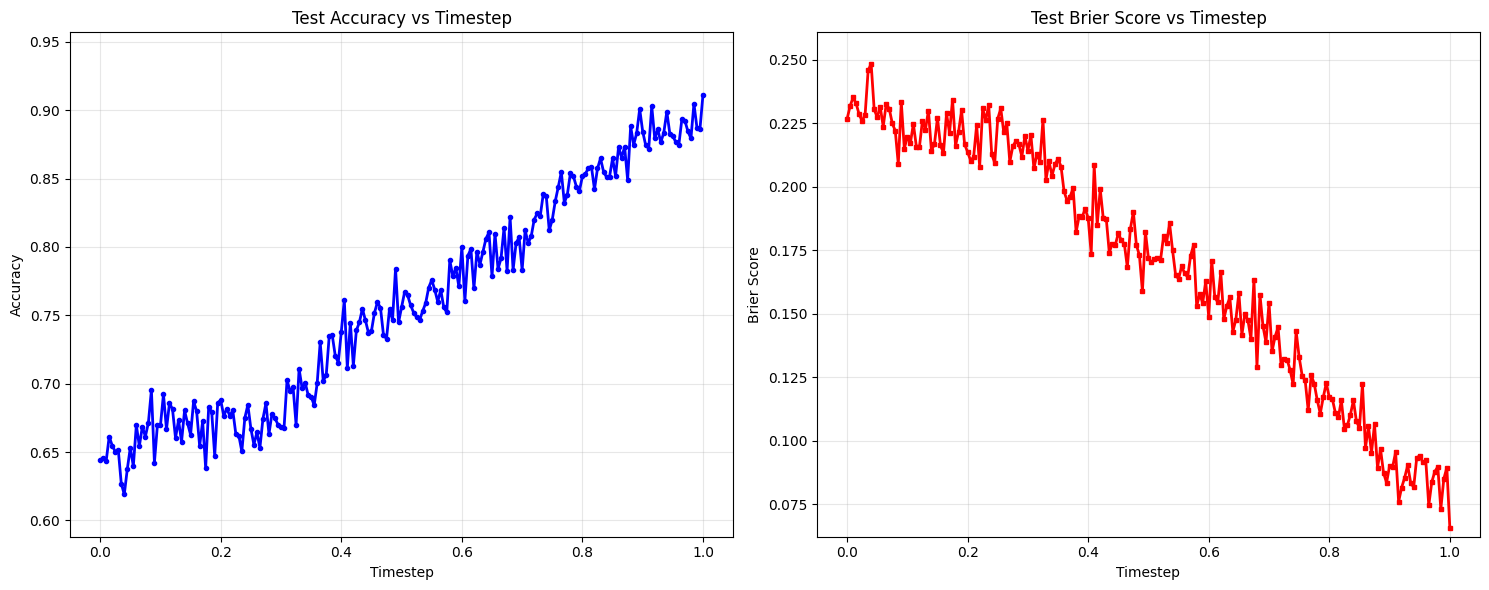


Summary Statistics:
Average Accuracy: 0.7585 ± 0.0813
Average Brier Score: 0.1689 ± 0.0493
Best Accuracy: 0.9113 at timestep 100.00%
Best Brier Score: 0.0654 at timestep 100.00%


In [121]:
# Test accuracy and Brier score of model for each timestep on test data and plot
accuracies = []
brier_scores = []
timesteps = []
def brier_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

for timestep, i in zip(ensemble_models, test_data.keys()):
    model = ensemble_models[timestep]
    # Convert test data to array
    y_test = np.array([row["label"] for row in test_data_seq[i]])
    X_test = np.array([row["rows"] for row in test_data_seq[i]])
    
    # Calculate accuracy
    accuracy = model.score(X_test, y_test)
    
    # Calculate Brier score
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probability predictions
    brier_score = brier_loss(y_test, y_test_pred_proba)
    
    print(f"Timestep {timestep:.2%}: Accuracy = {accuracy:.4f}, Brier Score = {brier_score:.4f}")
    accuracies.append(accuracy)
    brier_scores.append(brier_score)
    timesteps.append(timestep)

# Create subplots for both metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot accuracy
ax1.plot(timesteps, accuracies, 'b-', linewidth=2, marker='o', markersize=3)
ax1.set_xlabel("Timestep")
ax1.set_ylabel("Accuracy")
ax1.set_title("Test Accuracy vs Timestep")
ax1.grid(True, alpha=0.3)
ax1.set_ylim([min(accuracies) * 0.95, max(accuracies) * 1.05])

# Plot Brier score
ax2.plot(timesteps, brier_scores, 'r-', linewidth=2, marker='s', markersize=3)
ax2.set_xlabel("Timestep")
ax2.set_ylabel("Brier Score")
ax2.set_title("Test Brier Score vs Timestep")
ax2.grid(True, alpha=0.3)
ax2.set_ylim([min(brier_scores) * 0.95, max(brier_scores) * 1.05])

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Average Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Average Brier Score: {np.mean(brier_scores):.4f} ± {np.std(brier_scores):.4f}")
print(f"Best Accuracy: {max(accuracies):.4f} at timestep {timesteps[np.argmax(accuracies)]:.2%}")
print(f"Best Brier Score: {min(brier_scores):.4f} at timestep {timesteps[np.argmin(brier_scores)]:.2%}")

In [122]:
# Write predictions to csv file
from process_data import write_predictions
write_predictions(ensemble_models, interpolated_dir, [2024], 4, features, replace_nan_val = 0, phat_b = "ensemble_phat_b")

Loading data for 2024
Processed file:  game_401671629.csv
Processed file:  game_401671601.csv
Processed file:  game_401671826.csv
Processed file:  game_401671832.csv
Processed file:  game_401671749.csv
Processed file:  game_401671775.csv
Processed file:  game_401671761.csv
Processed file:  game_401671760.csv
Processed file:  game_401671774.csv
Processed file:  game_401671748.csv
Processed file:  game_401671833.csv
Processed file:  game_401671827.csv
Processed file:  game_401671600.csv
Processed file:  game_401671628.csv
Processed file:  game_401671616.csv
Processed file:  game_401671831.csv
Processed file:  game_401671825.csv
Processed file:  game_401671819.csv
Processed file:  game_401671762.csv
Processed file:  game_401671776.csv
Processed file:  game_401671789.csv
Processed file:  game_401671788.csv
Processed file:  game_401671777.csv
Processed file:  game_401671763.csv
Processed file:  game_401671818.csv
Processed file:  game_401671824.csv
Processed file:  game_401671830.csv
Proces